In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/catvsdog/CatvsDog/test/dog/1269.jpg
/kaggle/input/catvsdog/CatvsDog/test/dog/2193.jpg
/kaggle/input/catvsdog/CatvsDog/test/dog/2008.jpg
/kaggle/input/catvsdog/CatvsDog/test/dog/2081.jpg
/kaggle/input/catvsdog/CatvsDog/test/dog/1786.jpg
/kaggle/input/catvsdog/CatvsDog/test/dog/1075.jpg
/kaggle/input/catvsdog/CatvsDog/test/dog/1789.jpg
/kaggle/input/catvsdog/CatvsDog/test/dog/473.jpg
/kaggle/input/catvsdog/CatvsDog/test/dog/1411.jpg
/kaggle/input/catvsdog/CatvsDog/test/dog/1501.jpg
/kaggle/input/catvsdog/CatvsDog/test/dog/1385.jpg
/kaggle/input/catvsdog/CatvsDog/test/dog/333.jpg
/kaggle/input/catvsdog/CatvsDog/test/dog/369.jpg
/kaggle/input/catvsdog/CatvsDog/test/dog/56.jpg
/kaggle/input/catvsdog/CatvsDog/test/dog/654.jpg
/kaggle/input/catvsdog/CatvsDog/test/dog/1711.jpg
/kaggle/input/catvsdog/CatvsDog/test/dog/1940.jpg
/kaggle/input/catvsdog/CatvsDog/test/dog/212.jpg
/kaggle/input/catvsdog/CatvsDog/test/dog/2057.jpg
/kaggle/input/catvsdog/CatvsDog/test/dog/1009.jpg
/kaggle

In [1]:
import os

# Check the structure of the 'train' folder
train_dir = '/kaggle/input/catvsdog/CatvsDog/train'
print("Train directory contents:", os.listdir(train_dir))

# Check the structure of the 'test' folder
test_dir = '/kaggle/input/catvsdog/CatvsDog/test'
print("Test directory contents:", os.listdir(test_dir))


Train directory contents: ['dog', 'cat']
Test directory contents: ['dog', 'cat']


In [2]:
import os

# Paths to train and test directories
train_dir = '/kaggle/input/catvsdog/CatvsDog/train'
test_dir = '/kaggle/input/catvsdog/CatvsDog/test'

def count_images_in_folder(folder_path):
    # Dictionary to store counts for each subfolder
    image_counts = {}
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            # Count all files in the subfolder
            image_counts[subfolder] = len([
                f for f in os.listdir(subfolder_path)
                if os.path.isfile(os.path.join(subfolder_path, f))
            ])
    return image_counts

# Count images in train and test directories
train_image_counts = count_images_in_folder(train_dir)
test_image_counts = count_images_in_folder(test_dir)

print("Train Image Counts:", train_image_counts)
print("Test Image Counts:", test_image_counts)


Train Image Counts: {'dog': 5026, 'cat': 12500}
Test Image Counts: {'dog': 1071, 'cat': 1219}


In [3]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def define_model():
    # Load VGG19 pre-trained on ImageNet without the top classification layers
    base_model = VGG19(include_top=False, input_shape=(200, 200, 3))
    
    # Freeze the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification layers
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
    output = Dense(1, activation='sigmoid')(x)

    # Define the final model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [5]:
def plot_from_csv(file_path):
    # Read the CSV file
    data = pd.read_csv(file_path)

    # Check if required columns exist
    required_columns = {"Epoch", "Train Accuracy", "Val Accuracy", "Train Loss", "Val Loss"}
    if not required_columns.issubset(data.columns):
        print(f"CSV file must contain the columns: {required_columns}")
        return

    # Plot accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(data['Epoch'], data['Train Accuracy'], label='Train Accuracy', marker='o')
    plt.plot(data['Epoch'], data['Val Accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(data['Epoch'], data['Train Loss'], label='Train Loss', marker='o')
    plt.plot(data['Epoch'], data['Val Loss'], label='Validation Loss', marker='o')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Show plots
    plt.tight_layout()
    plt.show()

In [6]:
def run_test_harness():
    model = define_model()
    # Create data generator
    datagen = ImageDataGenerator(featurewise_center=True)
    
    # Specify ImageNet mean values for centering
    datagen.mean = [123.68, 116.779, 103.939]

    # Prepare iterators for training and testing datasets
    train_it = datagen.flow_from_directory(
        '/kaggle/input/catvsdog/CatvsDog/train',
        batch_size=32,
        target_size=(200, 200),
        class_mode='binary'
    )

    test_it = datagen.flow_from_directory(
        '/kaggle/input/catvsdog/CatvsDog/test',
        batch_size=32,
        target_size=(200, 200),
        class_mode='binary'
    )

    # Fit the model and store accuracy and loss values
    history = model.fit(
        train_it,
        validation_data=test_it,
        epochs=20,
    )

    # Save accuracy and loss data to CSV
    data = {
        'Epoch': np.arange(1, 21),
        'Train Accuracy': history.history['accuracy'],
        'Val Accuracy': history.history['val_accuracy'],
        'Train Loss': history.history['loss'],
        'Val Loss': history.history['val_loss']
    }

    df = pd.DataFrame(data)
    df.to_csv('training_history_vgg19.csv', index=False)  # Save to CSV in the Colab directory
    print(df)


In [7]:
run_test_harness()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 17526 images belonging to 2 classes.
Found 2290 images belonging to 2 classes.
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733841167.900349     107 service.cc:145] XLA service 0x7e5dcc005c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733841167.900408     107 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733841167.900413     107 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/548 ━━━━━━━━━━━━━━━━━━━━ 2:15:06 15s/step - accuracy: 0.2812 - loss: 13.2623

I0000 00:00:1733841179.881556     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


548/548 ━━━━━━━━━━━━━━━━━━━━ 137s 223ms/step - accuracy: 0.9345 - loss: 0.7243 - val_accuracy: 0.9450 - val_loss: 0.2869
Epoch 2/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 89s 161ms/step - accuracy: 0.9929 - loss: 0.0179 - val_accuracy: 0.9480 - val_loss: 0.4355
Epoch 3/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 89s 161ms/step - accuracy: 0.9990 - loss: 0.0038 - val_accuracy: 0.9520 - val_loss: 0.4604
Epoch 4/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 89s 161ms/step - accuracy: 0.9999 - loss: 4.3022e-04 - val_accuracy: 0.9524 - val_loss: 0.5215
Epoch 5/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 89s 161ms/step - accuracy: 1.0000 - loss: 2.3862e-04 - val_accuracy: 0.9524 - val_loss: 0.5114
Epoch 6/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 89s 161ms/step - accuracy: 1.0000 - loss: 8.2839e-05 - val_accuracy: 0.9511 - val_loss: 0.5371
Epoch 7/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 89s 161ms/step - accuracy: 1.0000 - loss: 4.5356e-05 - val_accuracy: 0.9520 - val_loss: 0.5499
Epoch 8/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 89s 161ms/step - accuracy: 1.0000 - l

In [8]:
import pandas as pd

# Data for the epochs
data = {
    "Epoch": list(range(1, 21)),
    "Accuracy": [0.9339, 0.9924, 0.9989, 0.9999, 0.9998, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000,
                 1.0000, 0.9999, 1.0000, 0.9998, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 0.9735],
    "Val_Accuracy": [0.9622, 0.9686, 0.9724, 0.9722, 0.9742, 0.9736, 0.9732, 0.9728, 0.9744, 0.9738,
                     0.9746, 0.9742, 0.9742, 0.9748, 0.9736, 0.9732, 0.9744, 0.9724, 0.9660, 0.9664],
    "Loss": [0.5989, 0.0220, 0.0042, 0.00085, 0.0035, 0.00079, 0.00013, 0.000045, 0.00020, 0.000027,
             0.000042, 0.00017, 0.000039, 0.00058, 0.000036, 0.000058, 0.000020, 0.00041, 0.00032, 0.3267],
    "Val_Loss": [0.1173, 0.1067, 0.1060, 0.1133, 0.1105, 0.1130, 0.1151, 0.1167, 0.1199, 0.1203,
                 0.1238, 0.1260, 0.1257, 0.1288, 0.1348, 0.1358, 0.1413, 0.1407, 0.2263, 0.2032]
}

# Create a DataFrame
df = pd.DataFrame(data)
df


,Epoch,Accuracy,Val_Accuracy,Loss,Val_Loss
0,1,0.9339,0.9622,0.598900,0.1173
1,2,0.9924,0.9686,0.022000,0.1067
2,3,0.9989,0.9724,0.004200,0.1060
3,4,0.9999,0.9722,0.000850,0.1133
4,5,0.9998,0.9742,0.003500,0.1105
5,6,0.9999,0.9736,0.000790,0.1130
6,7,1.0000,0.9732,0.000130,0.1151
7,8,1.0000,0.9728,0.000045,0.1167
8,9,1.0000,0.9744,0.000200,0.1199
9,10,1.0000,0.9738,0.000027,0.1203


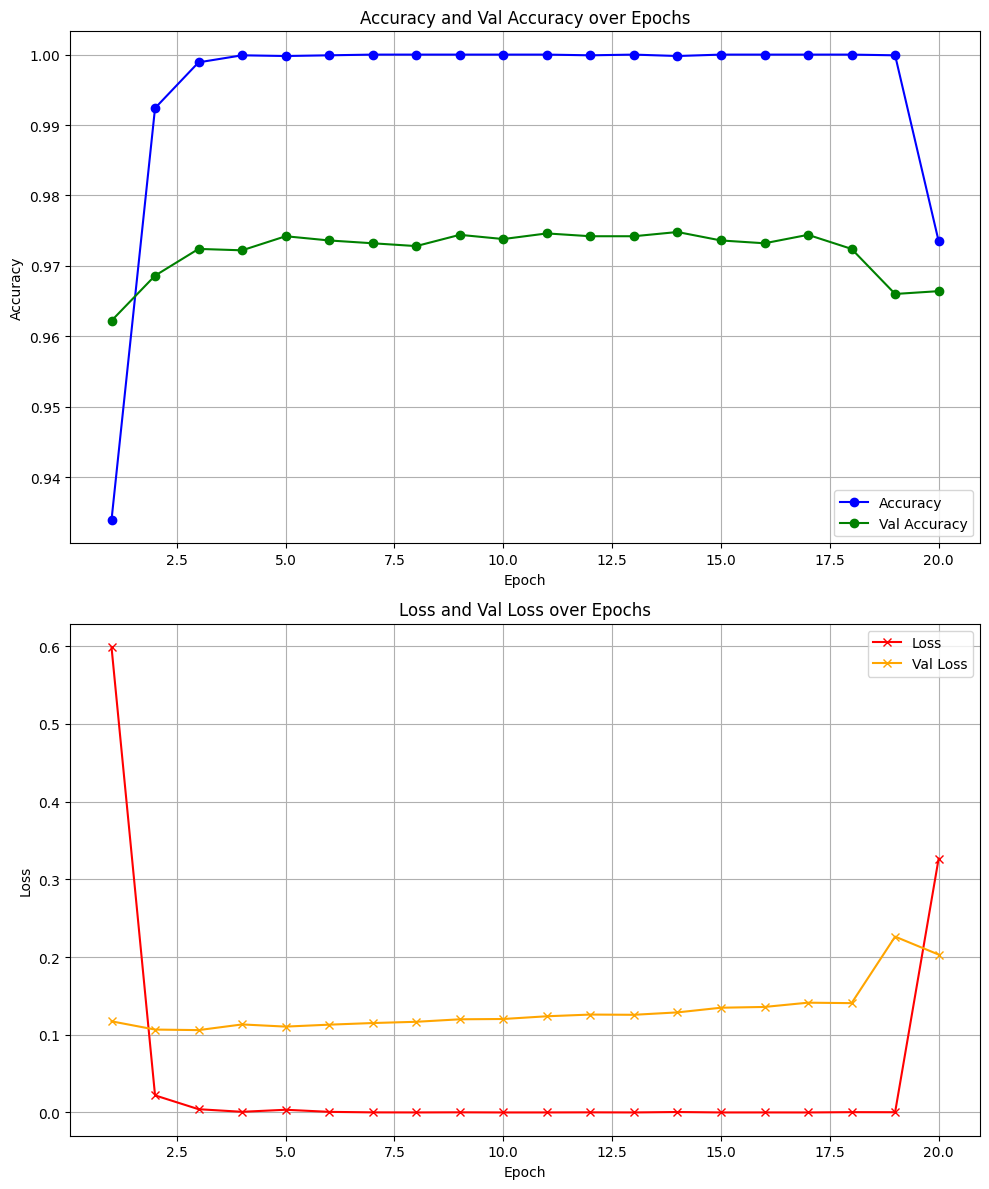

In [9]:
# Create two separate plots for Accuracy/Val Accuracy and Loss/Val Loss

fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Plot Accuracy and Val_Accuracy
axes[0].plot(df['Epoch'], df['Accuracy'], label='Accuracy', color='b', marker='o')
axes[0].plot(df['Epoch'], df['Val_Accuracy'], label='Val Accuracy', color='g', marker='o')
axes[0].set_title('Accuracy and Val Accuracy over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot Loss and Val_Loss
axes[1].plot(df['Epoch'], df['Loss'], label='Loss', color='r', marker='x')
axes[1].plot(df['Epoch'], df['Val_Loss'], label='Val Loss', color='orange', marker='x')
axes[1].set_title('Loss and Val Loss over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()
